In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Conv2d, InstanceNorm2d, ConvTranspose2d
from torch import optim 
import torch.nn.functional as F 
import torchvision

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this won't work if the drive is shared with you
# solution: right click on the shared project folder and select 'add shortcut to my drive'
%cd gdrive/My\ Drive/CS7643_Final_Project

In [ ]:
from vae_mnist import VAE

In [ ]:
pretrained_vae = VAE().eval().to(device)
pretrained_vae.load_state_dict(torch.load('vae_epoch_25.pth'))

for param in pretrained_vae.parameters():
  param.requires_grad_(False)

In [ ]:
class Decoder_classifier(nn.Module):
  def __init__(self):
    super(Decoder_classifier, self).__init__()
    self.fc1 = nn.Linear(20, 40)
    self.fc2 = nn.Linear(40, 40)
    self.fc3 = nn.Linear(40, 30)
    self.fc4 = nn.Linear(30, 20)
    self.fc5 = nn.Linear(20, 10)

    self.dropout = nn.Dropout(0.25)
  
  def forward(self, x):
    mu, logvar = pretrained_vae.encode(x.reshape(-1, 784))
    z = pretrained_vae.reparameterize(mu,logvar)
    
    out = F.selu(self.fc1(z))
    out = F.selu(self.fc2(out))
    out = F.selu(self.fc3(out))
    out = F.selu(self.fc4(out))
    out = self.fc5(out)
    return out

In [ ]:
def evaluate_model(model, dataloader, criterion = nn.CrossEntropyLoss()):
    """
    Calculates the average loss and accuracy of the model on a dataset
    """
    model.eval() # Notify all layers we're in eval mode instead of training mode
    loss, total, correct = 0, 0, 0
    n = 0
    with torch.no_grad():
      for xs, ys in dataloader:
          output = model(xs.to(device))
          loss += criterion(output, ys.to(device)).item()
          _, predictions = torch.max(output.data, 1)
          total += ys.size(0)
          correct += (predictions == ys.to(device)).sum().item()
          n += 1
    
    print(f'\nTest loss: {loss / n: .2f} | Test accuracy: {correct / total : .2f}')
    return loss / n, 100 * correct / total

In [ ]:
batch_size = 128

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
log_epoch = 10

In [ ]:
classifier = Decoder_classifier().to(device)
optimizer = optim.Adam(params = classifier.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
losses = []
test_losses = []
epochs = 200

In [ ]:
for epoch in range(1, epochs + 1):
  total = 0
  n = 0
  for x, y in train_data_loader:

    optimizer.zero_grad()
    
    out = classifier(x.to(device))
    loss = criterion(out, y.to(device))
    loss.backward()
    optimizer.step()

    total += loss.item()
    n += 1
  
  losses.append(total / n)
  test_loss, test_accuracy = evaluate_model(classifier, test_data_loader)
  # put model back in train mode after putting it in eval mode
  classifier.train()
  test_losses.append(test_loss)
  
  print('Epoch: {}, Avg Loss: {:.4f}'.format(epoch, total / n))


Test loss:  16.14 | Test accuracy:  0.37
Epoch: 1, Avg Loss: 53.5694

Test loss:  5.94 | Test accuracy:  0.43
Epoch: 2, Avg Loss: 9.3997

Test loss:  2.10 | Test accuracy:  0.45
Epoch: 3, Avg Loss: 3.2513

Test loss:  1.71 | Test accuracy:  0.44
Epoch: 4, Avg Loss: 1.8349

Test loss:  1.72 | Test accuracy:  0.46
Epoch: 5, Avg Loss: 1.6171

Test loss:  1.47 | Test accuracy:  0.49
Epoch: 6, Avg Loss: 1.5307

Test loss:  1.41 | Test accuracy:  0.50
Epoch: 7, Avg Loss: 1.4701

Test loss:  1.38 | Test accuracy:  0.52
Epoch: 8, Avg Loss: 1.4158

Test loss:  1.34 | Test accuracy:  0.54
Epoch: 9, Avg Loss: 1.3742

Test loss:  1.31 | Test accuracy:  0.54
Epoch: 10, Avg Loss: 1.3332

Test loss:  1.30 | Test accuracy:  0.54
Epoch: 11, Avg Loss: 1.3423

Test loss:  1.29 | Test accuracy:  0.55
Epoch: 12, Avg Loss: 1.3255

Test loss:  1.24 | Test accuracy:  0.57
Epoch: 13, Avg Loss: 1.2839

Test loss:  1.24 | Test accuracy:  0.57
Epoch: 14, Avg Loss: 1.2514

Test loss:  1.19 | Test accuracy:  0.59


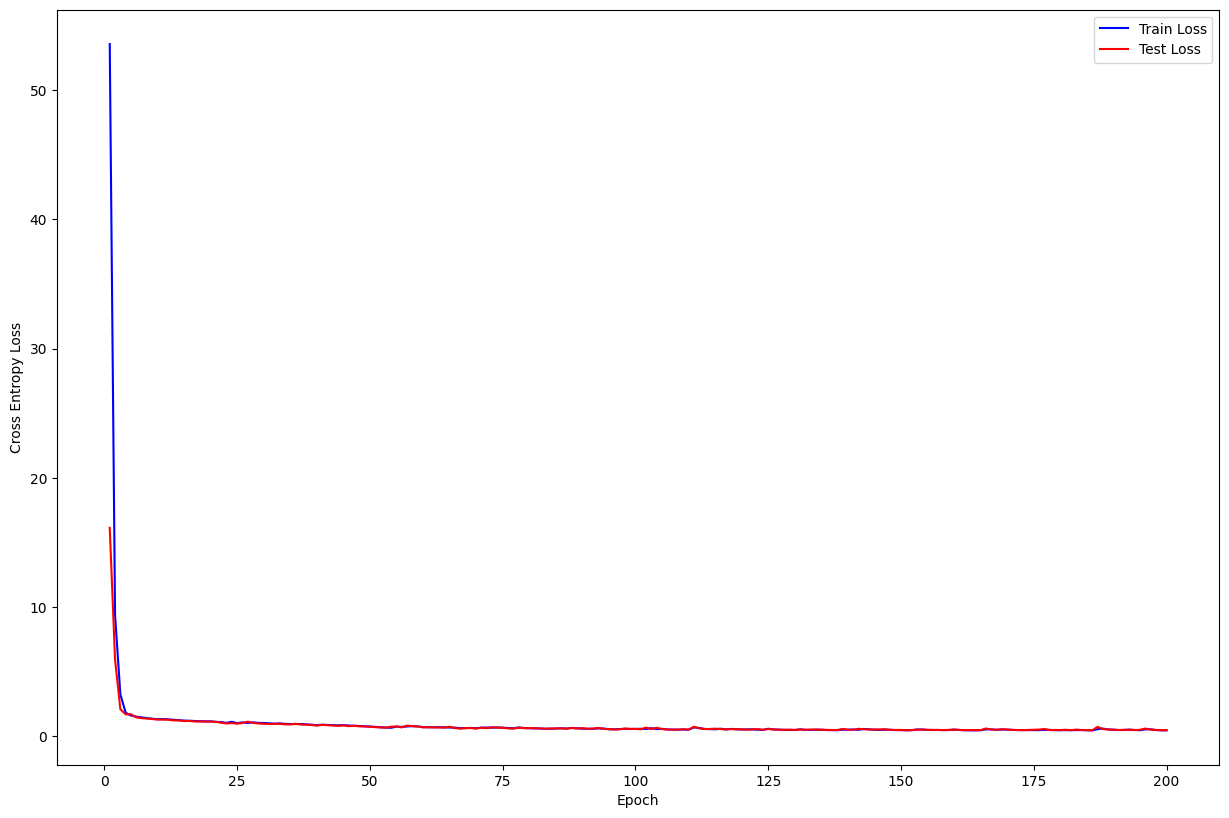

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 100 

plt.plot(list(range(1, epochs + 1)), losses, color='blue')
plt.plot(list(range(1, epochs + 1)), test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
evaluate_model(classifier, test_data_loader)


Test loss:  0.48 | Test accuracy:  0.84


(0.48114304037033756, 83.89)

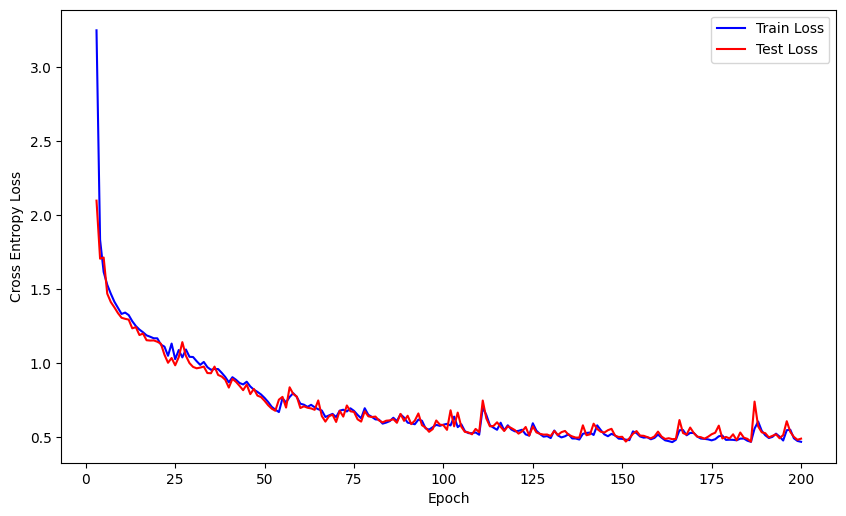

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 

plt.plot(list(range(1, epochs + 1))[2:], losses[2:], color='blue')
plt.plot(list(range(1, epochs + 1))[2:], test_losses[2:], color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
torch.save(classifier.state_dict(), 'vae_classifier_mnist_v3.pt')

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_mnist(model, dataloader):
  preds, labels = torch.Tensor([]).to(device), torch.Tensor([]).to(device)
  
  with torch.no_grad():
    for x_batch, y_batch in dataloader:
      out = model(x_batch.to(device))
      preds = torch.cat((preds, out), dim = 0)
      labels = torch.cat((labels, y_batch.to(device)), dim = 0)
  
  preds = torch.argmax(preds, dim = 1)

  count_matrix = torch.zeros((10, 10)).to(device)
  
  for pred, label in zip(preds, labels):
    count_matrix[int(pred)][int(label)] += 1
  
  count_matrix = count_matrix / count_matrix.sum(axis = 1)

  plt.imshow(count_matrix.cpu(), interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  marks = list(range(10))
  class_names = [str(x) for x in range(1, 11)]
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.xticks(marks, class_names)
  plt.yticks(marks, class_names)

  threshold = count_matrix.max() / 2
  # label each grid with its count
  for i in range(10):
    for j in range(10):
      plt.text(j, i, format(count_matrix[i][j], '.2f'), ha="center", va="center",
                    color="white" if count_matrix[i][j] > threshold else "black")

  
  plt.colorbar()
  plt.show()

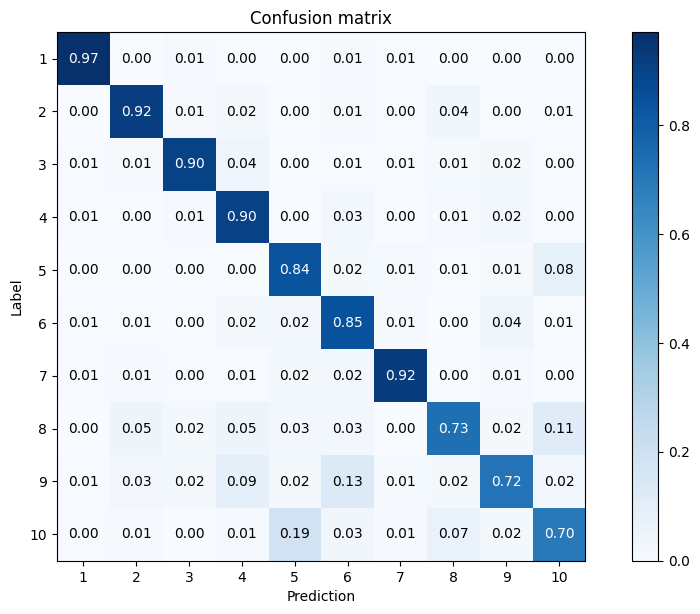

In [ ]:
plot_confusion_matrix_mnist(classifier, test_data_loader)